# Konfiguracja narzędzia graficznego

In [17]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [18]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie

### Obliczanie wyznacznika macierzy

In [19]:
def det(a,b,c): # (wspolrzedne a, wspolrzedne b, wspolrzedne c)
    matrix=[[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]]
    return (matrix[0][0] * matrix[1][1] * matrix[2][2] + 
            matrix[1][0] * matrix[2][1] * matrix[0][2] + 
            matrix[2][0] * matrix[0][1] * matrix[1][2] - 
            matrix[2][0] * matrix[1][1] * matrix[0][2] - 
            matrix[1][0] * matrix[0][1] * matrix[2][2] - 
            matrix[0][0] * matrix[2][1] * matrix[1][2])

### Kategoryzacja punktu pod względem położenia wobec prostej

In [20]:
def categorize_point(a,b,c,eps=10**(-8)): #(wspolrzedne a, wspolrzedne b, wspolrzedne c, tolerancja dla zera)
    temp=det(a,b,c)
    if abs(temp) < eps:
        return "collinear"
    elif temp > 0:
        return "left" # <pi
    else:
        return "right" # >pi

### Funkcje do obsługi wizualizacji

In [21]:
def plot_to_lines(plot):
    return plot.get_added_figure()[0].lines

def lines_to_points(lines):
    return [x[0] for x in lines]

### Znajdowanie punktów o skrajnych współrzędnych y

In [22]:
def index_of_max_y(points):
    max_y = float('-inf')
    index = -1
    for i in range(len(points)):
        if points[i][1] > max_y:
            max_y = points[i][1]
            index = i
    return index

def index_of_min_y(points):
    min_y = float('inf')
    index = -1
    for i in range(len(points)):
        if points[i][1] < min_y:
            min_y = points[i][1]
            index = i
    return index

### Sprawdzanie monotoniczności wielokąta

In [23]:
def is_monotonous(points):
    n = len(points)
    max_y_index = index_of_max_y(points)
    min_y_index = index_of_min_y(points)
    
    # Left branch
    previous_index = max_y_index    
    while previous_index != min_y_index:
        current_index = previous_index + 1
        if current_index == n:
            current_index = 0
        if points[previous_index][1] <= points[current_index][1]:
            return False
        previous_index = current_index
        
    # Right branch
    previous_index = max_y_index 
    while previous_index != min_y_index:
        current_index = previous_index - 1
        if current_index == -1:
            current_index = n-1
        if points[previous_index][1] <= points[current_index][1]:
            return False
        previous_index = current_index
        
    return True

### Kategoryzacja wierzchołków

In [24]:
def categorize_points(points):
    START = 0
    END = 1
    JOIN = 2
    DIV = 3
    CORRECT = 4
    n = len(points)
    TOL=10**(-8)
    marked_points = [[], [], [], [], [], []]
    
    current = 0 
    n1 = n-1
    n2 = 1
    
    for current in range(n):
        n1 = current - 1
        n2 = current + 1
        
        if n1 == -1: n1 = n-1
        if n2 == n: n2 = 0
        
        if points[n1][1] > points[current][1] > points[n2][1] or points[n1][1] < points[current][1] < points[n2][1]:
            marked_points[CORRECT].append(points[current])
        elif points[n1][1] > points[current][1] and points[n2][1] > points[current][1]:
            if det(points[n1], points[current], points[n2]) > TOL:
                marked_points[END].append(points[current])
            else:
                marked_points[JOIN].append(points[current])
        else:
            if det(points[n1], points[current], points[n2]) > TOL:
                marked_points[START].append(points[current])
            else:
                marked_points[DIV].append(points[current])
        
    return marked_points

def visualise_marked_points(marked_points, lines = []):
    scene = Scene([PointsCollection(marked_points[START], color="green"), PointsCollection(marked_points[END], color="red"), PointsCollection(marked_points[JOIN], color="blue"), PointsCollection(marked_points[DIV], color="lightblue"), PointsCollection(marked_points[CORRECT], color="brown")], [LinesCollection(lines, color="lightgray")])
    plot = Plot(scenes=[scene])
    plot.draw()

### Triangulacja

In [25]:
START = 0
END = 1
JOIN = 2
DIV = 3
CORRECT = 4

def belongs(v1, v2, v3, branch):
    if branch == 1:
        return det(v1, v2, v3) > 0
    else:
        return det(v1, v2, v3) < 0

def triangulate(points):
    if not is_monotonous(points):
        print("Figura jest niemonotoniczna!")
        return ([], [])
    
    max_y_index = index_of_max_y(points)
    min_y_index = index_of_min_y(points)
    b_points = []
    for i in range(len(points)):
        if min_y_index < i <= max_y_index:
            b_points.append((points[i], 0))
        else:
            b_points.append((points[i], 1))
    b_points.sort(reverse = True, key = lambda k: (k[0][1], k[0][0], k[1]))
    
    diagonals = []
    stack = []
    scenes = []
    
    stack.append(b_points[0])
    stack.append(b_points[1])
    scenes.append(Scene([PointsCollection(points), PointsCollection([b_points[0][0]], color="red")], [LinesCollection(diagonals.copy())]))

    diagonals.append([b_points[0][0], b_points[1][0]])
    
    scenes.append(Scene([PointsCollection(points), PointsCollection([b_points[1][0]], color="red")], [LinesCollection(diagonals.copy())]))
    
    for i in range(2, len(b_points)):
        if stack[-1][1] != b_points[i][1]:
            while len(stack) > 0:
                u = stack.pop()
                diagonals.append([u[0], b_points[i][0]])
                scenes.append(Scene([PointsCollection(points), PointsCollection([b_points[i][0]], color="red")], [LinesCollection(diagonals.copy())]))
            stack.append(b_points[i-1])
            stack.append(b_points[i])
        else:
            u = stack.pop()
            diagonals.append([b_points[i][0], u[0]])
            scenes.append(Scene([PointsCollection(points), PointsCollection([b_points[i][0]], color="red")], [LinesCollection(diagonals.copy())]))
            while len(stack) > 0 and belongs(b_points[i][0], stack[-1][0], u[0], b_points[i][1]):
                diagonals.append([stack[-1][0], b_points[i][0]])
                u = stack.pop()
                scenes.append(Scene([PointsCollection(points), PointsCollection([b_points[i][0]], color="red")], [LinesCollection(diagonals.copy())]))
            stack.append(u)
            stack.append(b_points[i])
    final_scene = Scene([PointsCollection(points)], [LinesCollection(diagonals.copy())])
    scenes = [final_scene] + scenes                
    return (diagonals, scenes)

# Interaktywne tworzenie wielokątów, ich zapis i odczyt

In [26]:
def points_from_plot(plot):
    points = []
    lines = plot.get_added_figure()[0].lines
    for l in lines:
        points.append(l[0])
    points.append(lines[len(lines) - 1][1])
    return points

def convert_to_lines(points):
    lines = []
    for p in range(len(points)-1):
        lines.append((points[p], points[p+1]))
    lines.append((points[-1], points[0]))
    return lines

def save_file(file_name, plot):
    with open(file_name+'.json', 'w') as file:
        file.write(js.dumps(plot_to_lines(plot)))

def read_file(file_name):
    with open(file_name+'.json', 'r') as file:
        lines = js.loads(file.read())
    points = lines_to_points(lines)
    plot = Plot(lines=[LinesCollection(lines)])
    return plot,points,lines

##### Kliknij dodaj figurę, następnie narysuj ją i zamknij interfejs rysunku (prawy górny róg)

<IPython.core.display.Javascript object>


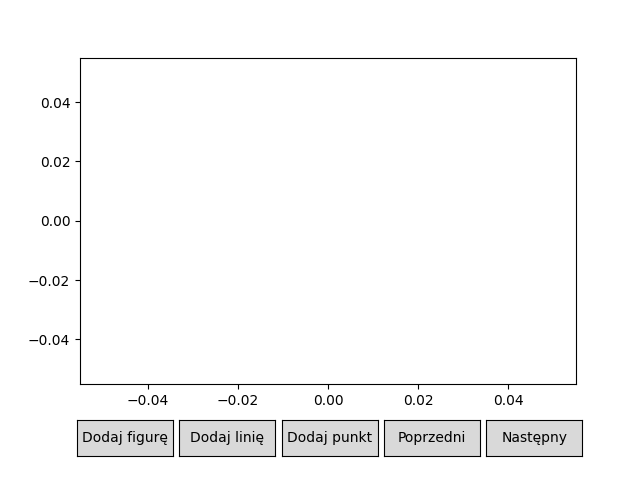

In [27]:
%matplotlib notebook

plot1=Plot()
plot1.draw()

#### Zapis figury do pliku

In [57]:
save_file("new_file", plot1)

## Wizualizacja zestawów

#### Zestaw A

<IPython.core.display.Javascript object>


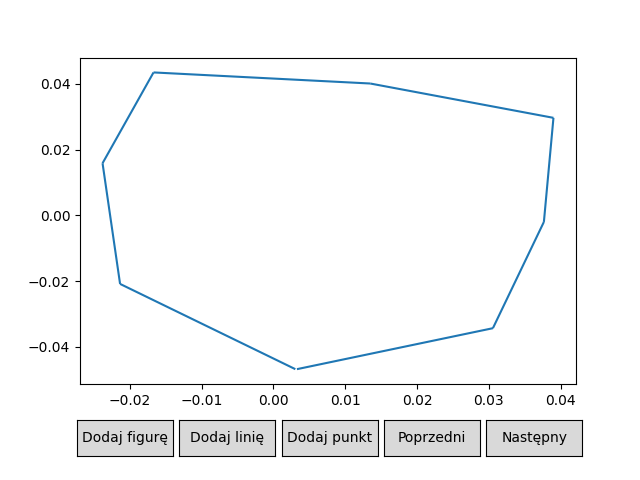

In [28]:
%matplotlib notebook
read_file("figura")[0].draw()

#### Zestaw B

<IPython.core.display.Javascript object>


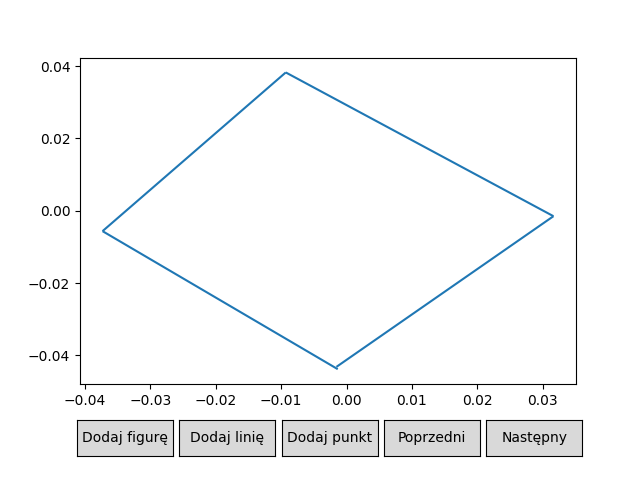

In [29]:
%matplotlib notebook
read_file("czworokat")[0].draw()

#### Zestaw C

<IPython.core.display.Javascript object>


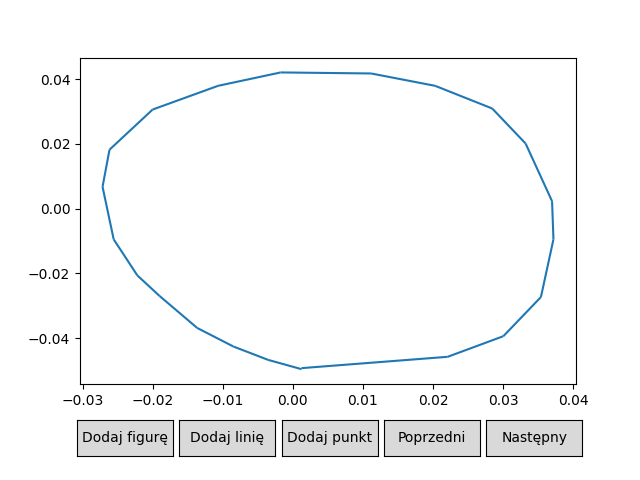

In [30]:
%matplotlib notebook
read_file("okrag")[0].draw()

#### Zestaw D

<IPython.core.display.Javascript object>


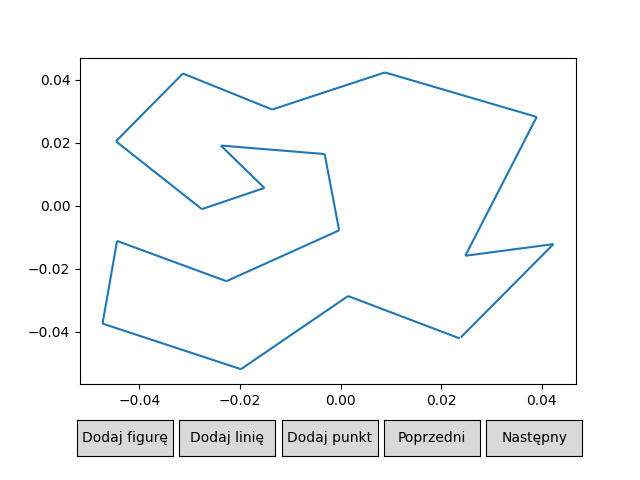

In [31]:
%matplotlib notebook
read_file("non_monotonous")[0].draw()

#### Zestaw E

<IPython.core.display.Javascript object>


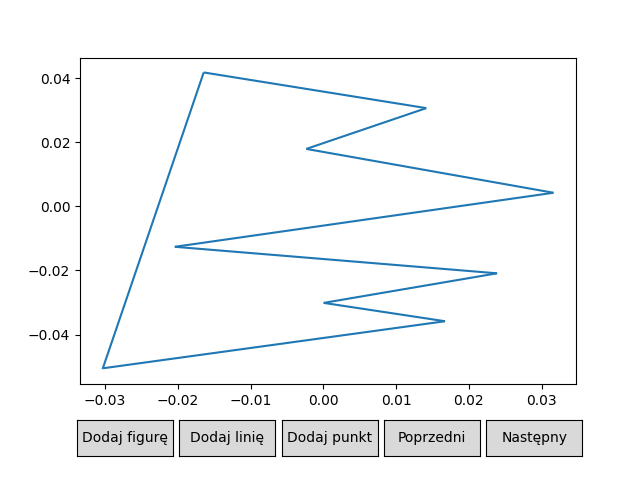

In [32]:
%matplotlib notebook
read_file("flag")[0].draw()

#### Zestaw F

<IPython.core.display.Javascript object>


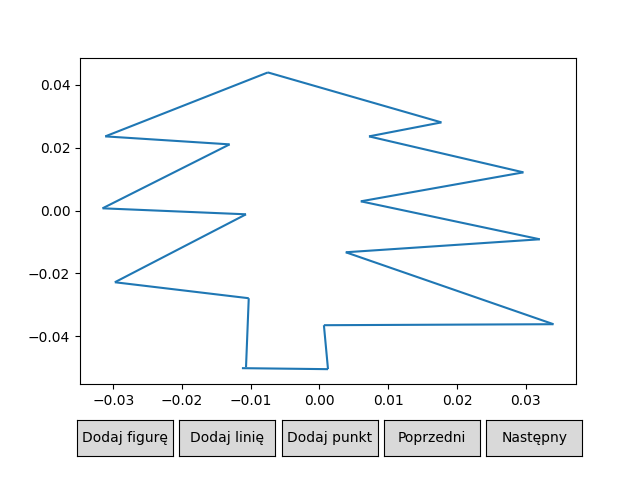

In [33]:
%matplotlib notebook
read_file("choinka")[0].draw()

<IPython.core.display.Javascript object>


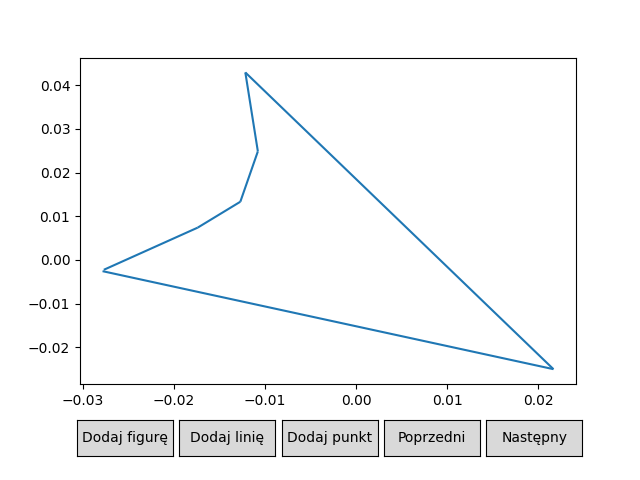

In [34]:
%matplotlib notebook
read_file("arrow")[0].draw()

## Kategoryzacja wierzchołków

<IPython.core.display.Javascript object>


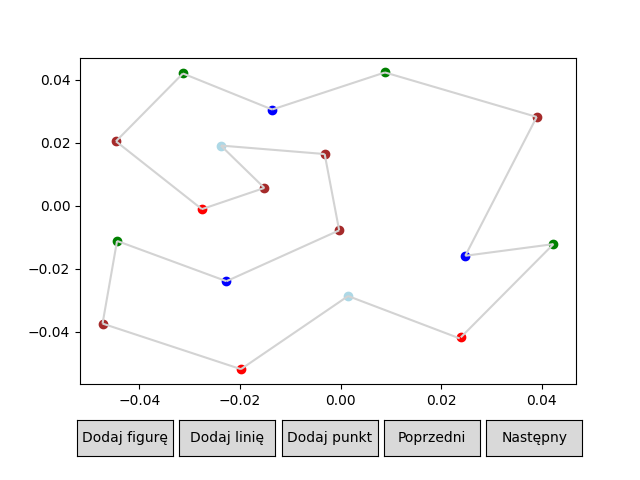

In [35]:
%matplotlib notebook
x=read_file("non_monotonous")
visualise_marked_points(categorize_points(x[1]),x[2])

## Triangulacja - wizualizacja

<IPython.core.display.Javascript object>


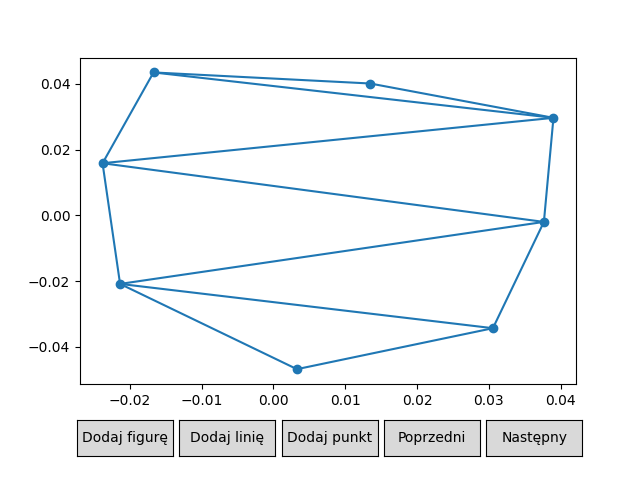

In [36]:
%matplotlib notebook
with open('figura.json', 'r') as file:
    lines = js.loads(file.read())
points = lines_to_points(lines)

result = triangulate(points)
plot = Plot(scenes=result[1])
plot.draw()

<IPython.core.display.Javascript object>


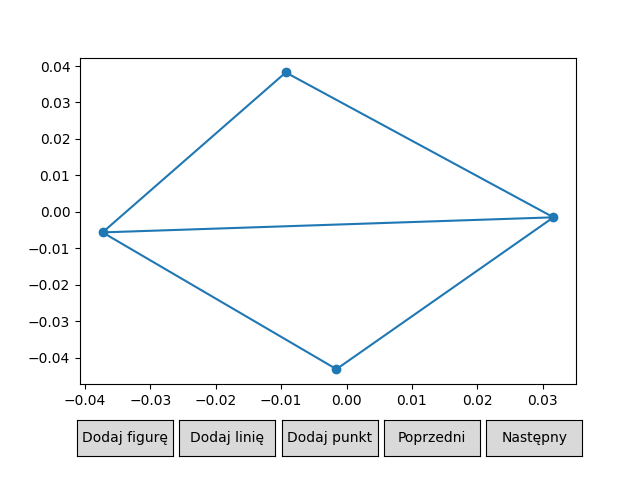

In [37]:
%matplotlib notebook
with open('czworokat.json', 'r') as file:
    lines = js.loads(file.read())
points = lines_to_points(lines)

result = triangulate(points)
plot = Plot(scenes=result[1])
plot.draw()

<IPython.core.display.Javascript object>


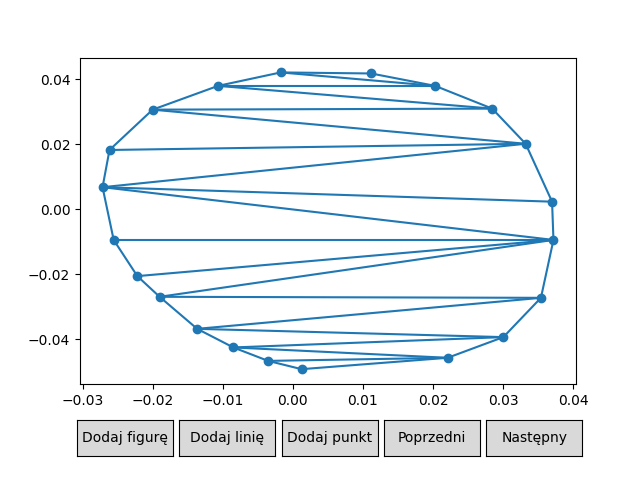

In [38]:
%matplotlib notebook
with open('okrag.json', 'r') as file:
    lines = js.loads(file.read())
points = lines_to_points(lines)

result = triangulate(points)
plot = Plot(scenes=result[1])
plot.draw()

<IPython.core.display.Javascript object>


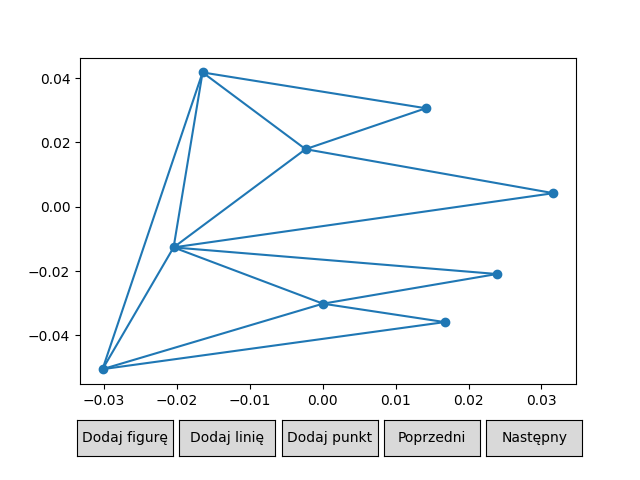

In [39]:
%matplotlib notebook
with open('flag.json', 'r') as file:
    lines = js.loads(file.read())
points = lines_to_points(lines)

result = triangulate(points)
plot = Plot(scenes=result[1])
plot.draw()

<IPython.core.display.Javascript object>


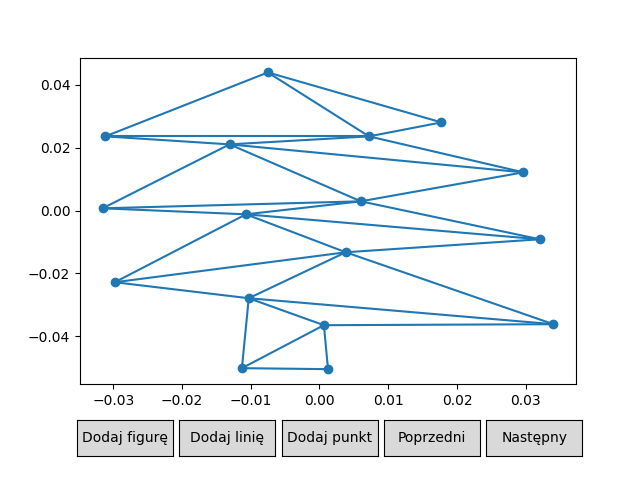

In [40]:
%matplotlib notebook
with open('choinka.json', 'r') as file:
    lines = js.loads(file.read())
points = lines_to_points(lines)

result = triangulate(points)
plot = Plot(scenes=result[1])
plot.draw()

<IPython.core.display.Javascript object>


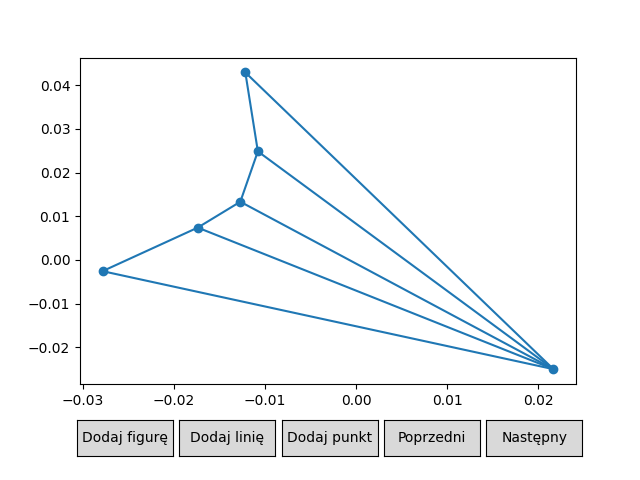

In [42]:
%matplotlib notebook
with open('arrow.json', 'r') as file:
    lines = js.loads(file.read())
points = lines_to_points(lines)

result = triangulate(points)
plot = Plot(scenes=result[1])
plot.draw()